In [1]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Yolov1
from dataset import VOCDataset
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import YoloLoss

In [2]:
seed = 123
torch.manual_seed(seed)

In [10]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE =  "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 200
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "images"
LABEL_DIR = "labels"

In [12]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
#         for x, y in train_loader:
#             x = x.to(DEVICE)
#             for idx in range(8):
#                 bboxes = cellboxes_to_boxes(model(x))
#                 bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
#                 plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

#             import sys
#             sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        if mean_avg_prec > 0.9:
            checkpoint = {
               "state_dict": model.state_dict(),
               "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
            import time
            time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()

Train mAP: 0.0


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.11s/it, loss=927]


Mean loss was 893.5388692220052
Train mAP: 0.0


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.63s/it, loss=529]


Mean loss was 547.9910634358724
Train mAP: 0.0


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.65s/it, loss=424]


Mean loss was 438.08388264973956
Train mAP: 0.0


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.73s/it, loss=322]


Mean loss was 364.2706349690755
Train mAP: 2.723311263252981e-05


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.64s/it, loss=286]


Mean loss was 306.4219029744466
Train mAP: 3.3856988466141047e-06


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:32<00:00, 15.35s/it, loss=297]


Mean loss was 283.49988047281903
Train mAP: 4.965784683008678e-05


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.71s/it, loss=225]


Mean loss was 229.68675486246744
Train mAP: 9.384383702126797e-06


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.75s/it, loss=171]


Mean loss was 220.79038747151694
Train mAP: 0.0


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.55s/it, loss=248]


Mean loss was 198.2992172241211
Train mAP: 0.012901226058602333


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.03s/it, loss=218]


Mean loss was 172.38013458251953
Train mAP: 0.07712806016206741


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.00s/it, loss=161]


Mean loss was 160.8157221476237
Train mAP: 0.14935952425003052


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.59s/it, loss=84.6]


Mean loss was 130.12014389038086
Train mAP: 0.26729997992515564


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.07s/it, loss=78.2]


Mean loss was 126.82898712158203
Train mAP: 0.3494108021259308


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.88s/it, loss=95]


Mean loss was 123.23527272542317
Train mAP: 0.450047105550766


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.91s/it, loss=124]


Mean loss was 114.55276870727539
Train mAP: 0.5034860372543335


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.73s/it, loss=99.7]


Mean loss was 107.13115056355794
Train mAP: 0.5701375603675842


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.71s/it, loss=127]


Mean loss was 95.11914825439453
Train mAP: 0.6085314750671387


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.73s/it, loss=101]


Mean loss was 94.58274332682292
Train mAP: 0.6472925543785095


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.68s/it, loss=82.2]


Mean loss was 87.57595189412434
Train mAP: 0.700870156288147


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.60s/it, loss=79.3]


Mean loss was 82.24813588460286
Train mAP: 0.7767091393470764


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.58s/it, loss=71.2]


Mean loss was 82.55979029337566
Train mAP: 0.6796535849571228


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.61s/it, loss=60.1]


Mean loss was 81.38161913553874
Train mAP: 0.7043279409408569


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.69s/it, loss=41.8]


Mean loss was 68.60828590393066
Train mAP: 0.8159492611885071


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.59s/it, loss=101]


Mean loss was 76.08385721842448
Train mAP: 0.8023903965950012


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.59s/it, loss=70.4]


Mean loss was 67.23614756266277
Train mAP: 0.8238571286201477


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.57s/it, loss=62.5]


Mean loss was 61.44585355122884
Train mAP: 0.8755048513412476


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.54s/it, loss=68.2]


Mean loss was 58.55042012532552
Train mAP: 0.8640960454940796


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.52s/it, loss=40.8]


Mean loss was 57.95574124654134
Train mAP: 0.8308584094047546


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.53s/it, loss=52.1]


Mean loss was 57.372918446858726
Train mAP: 0.9070698618888855
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:27<00:00, 14.61s/it, loss=40.1]


Mean loss was 55.11176999409994
Train mAP: 0.9105877876281738
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.53s/it, loss=66.2]


Mean loss was 53.58873748779297
Train mAP: 0.8330429792404175


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.78s/it, loss=39.6]


Mean loss was 55.3751163482666
Train mAP: 0.8286938667297363


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:27<00:00, 14.59s/it, loss=52.6]


Mean loss was 52.47450637817383
Train mAP: 0.8446532487869263


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.95s/it, loss=62.2]


Mean loss was 49.4422550201416
Train mAP: 0.8903135061264038


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:22<00:00, 13.73s/it, loss=40.4]


Mean loss was 44.27708117167155
Train mAP: 0.8663811683654785


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:20<00:00, 13.34s/it, loss=47.9]


Mean loss was 47.43276023864746
Train mAP: 0.8451911807060242


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.50s/it, loss=64.2]


Mean loss was 51.02256838480631
Train mAP: 0.8588559031486511


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.98s/it, loss=48.6]


Mean loss was 45.56499735514323
Train mAP: 0.9110836982727051
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.96s/it, loss=55.2]


Mean loss was 45.00763702392578
Train mAP: 0.9081584811210632
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.09s/it, loss=32]


Mean loss was 44.911078453063965
Train mAP: 0.8725415468215942


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.66s/it, loss=55.8]


Mean loss was 45.48278649648031
Train mAP: 0.8430105447769165


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.63s/it, loss=37.4]


Mean loss was 43.2155958811442
Train mAP: 0.8687965273857117


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.65s/it, loss=65.5]


Mean loss was 44.84719785054525
Train mAP: 0.8967120051383972


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.57s/it, loss=38.1]


Mean loss was 48.060150146484375
Train mAP: 0.8803238868713379


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.55s/it, loss=50.6]


Mean loss was 47.541730880737305
Train mAP: 0.8523905873298645


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.63s/it, loss=45.4]


Mean loss was 39.0490976969401
Train mAP: 0.896224319934845


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.57s/it, loss=41.9]


Mean loss was 46.47511672973633
Train mAP: 0.8430625200271606


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.58s/it, loss=31.9]


Mean loss was 41.555898348490395
Train mAP: 0.8866038918495178


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.50s/it, loss=51.2]


Mean loss was 38.73365847269694
Train mAP: 0.9025048017501831
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.39s/it, loss=29.8]


Mean loss was 36.17132600148519
Train mAP: 0.8530782461166382


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it, loss=35.6]


Mean loss was 36.58841609954834
Train mAP: 0.8595277667045593


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.52s/it, loss=29.2]


Mean loss was 36.82524108886719
Train mAP: 0.8526612520217896


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.55s/it, loss=52.4]


Mean loss was 37.406395276387535
Train mAP: 0.8843077421188354


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.61s/it, loss=44.9]


Mean loss was 35.56266943613688
Train mAP: 0.9356168508529663
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=32.9]


Mean loss was 35.650455474853516
Train mAP: 0.8717054128646851


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.57s/it, loss=37.7]


Mean loss was 35.17595640818278
Train mAP: 0.8754763603210449


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.52s/it, loss=31.3]


Mean loss was 32.42581335703532
Train mAP: 0.9054495096206665
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=47.1]


Mean loss was 36.14224624633789
Train mAP: 0.9000142216682434
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.18s/it, loss=35.3]


Mean loss was 38.42616653442383
Train mAP: 0.8756291270256042


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.69s/it, loss=33.1]


Mean loss was 35.44316291809082
Train mAP: 0.8276172876358032


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it, loss=37]


Mean loss was 44.491319020589195
Train mAP: 0.8643646240234375


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it, loss=48.4]


Mean loss was 44.04865996042887
Train mAP: 0.8601123690605164


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.57s/it, loss=36.4]


Mean loss was 40.225951512654625
Train mAP: 0.8872296214103699


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.43s/it, loss=52.2]


Mean loss was 37.54371325174967
Train mAP: 0.8896633982658386


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.44s/it, loss=43.4]


Mean loss was 35.43557675679525
Train mAP: 0.8865660429000854


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.44s/it, loss=34.3]


Mean loss was 33.10459677378336
Train mAP: 0.8507009744644165


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.46s/it, loss=32.1]


Mean loss was 33.62746047973633
Train mAP: 0.8657593727111816


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.46s/it, loss=30.9]


Mean loss was 29.58765411376953
Train mAP: 0.8550146222114563


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.40s/it, loss=31.1]


Mean loss was 29.616992632548016
Train mAP: 0.8756564855575562


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.60s/it, loss=36.3]


Mean loss was 29.97076479593913
Train mAP: 0.8435562252998352


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.49s/it, loss=21.3]


Mean loss was 32.086728731791176
Train mAP: 0.8570516705513


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it, loss=33.1]


Mean loss was 27.480774243672688
Train mAP: 0.911983847618103
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it, loss=24.5]


Mean loss was 27.07078266143799
Train mAP: 0.8897069096565247


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.55s/it, loss=24.4]


Mean loss was 24.763434727986652
Train mAP: 0.9126886129379272
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.42s/it, loss=23.8]


Mean loss was 24.910093943277996
Train mAP: 0.8839268684387207


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it, loss=16.4]


Mean loss was 21.954387029012043
Train mAP: 0.9182285070419312
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.12s/it, loss=23.7]


Mean loss was 21.375351905822754
Train mAP: 0.8971219062805176


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.58s/it, loss=20.3]


Mean loss was 24.180456320444744
Train mAP: 0.9089163541793823
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.19s/it, loss=26.9]


Mean loss was 24.604286511739094
Train mAP: 0.9398294687271118
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.20s/it, loss=22]


Mean loss was 23.305011749267578
Train mAP: 0.8861861228942871


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.50s/it, loss=29.5]


Mean loss was 24.899098078409832
Train mAP: 0.9636468291282654
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.23s/it, loss=21.2]


Mean loss was 20.644368807474773
Train mAP: 0.9581612348556519
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.23s/it, loss=26.4]


Mean loss was 21.683603922526043
Train mAP: 0.9336881637573242
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=26]


Mean loss was 21.53907076517741
Train mAP: 0.8774153590202332


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.51s/it, loss=38.2]


Mean loss was 23.46805222829183
Train mAP: 0.8973997831344604


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.50s/it, loss=22.5]


Mean loss was 22.25974686940511
Train mAP: 0.8712153434753418


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.55s/it, loss=18.6]


Mean loss was 20.317182699839275
Train mAP: 0.8923705220222473


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.51s/it, loss=18.6]


Mean loss was 18.916176160176594
Train mAP: 0.9110774993896484
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.58s/it, loss=23.4]


Mean loss was 19.25629488627116
Train mAP: 0.9219636917114258
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.49s/it, loss=27.7]


Mean loss was 18.151415189107258
Train mAP: 0.9204754829406738
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.68s/it, loss=14.4]


Mean loss was 18.689818223317463
Train mAP: 0.9205422401428223
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=18.2]


Mean loss was 20.038458506266277
Train mAP: 0.9348720908164978
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.23s/it, loss=20.2]


Mean loss was 19.86803976694743
Train mAP: 0.9466816782951355
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.65s/it, loss=22.5]


Mean loss was 20.08849557240804
Train mAP: 0.8990480303764343


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.58s/it, loss=38.3]


Mean loss was 17.695419311523438
Train mAP: 0.9438433647155762
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=16.5]


Mean loss was 16.814812024434406
Train mAP: 0.9337573051452637
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.27s/it, loss=17.6]


Mean loss was 16.793167273203533
Train mAP: 0.9051429033279419
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=30.5]


Mean loss was 16.531353791554768
Train mAP: 0.9909284710884094
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=16.3]


Mean loss was 18.637113094329834
Train mAP: 0.8965484499931335


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.54s/it, loss=13.2]


Mean loss was 17.05189339319865
Train mAP: 0.9250177145004272
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.15s/it, loss=19]


Mean loss was 17.092036724090576
Train mAP: 0.9276925325393677
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.20s/it, loss=26]


Mean loss was 17.318151315053303
Train mAP: 0.9302166104316711
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.23s/it, loss=14.6]


Mean loss was 16.52129602432251
Train mAP: 0.9491782188415527
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.21s/it, loss=20]


Mean loss was 16.92221721013387
Train mAP: 0.9507055282592773
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=12.5]


Mean loss was 16.052523771921795
Train mAP: 0.9433344006538391
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.20s/it, loss=28.9]


Mean loss was 19.207765579223633
Train mAP: 0.8788642883300781


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.47s/it, loss=14.6]


Mean loss was 17.3328758875529
Train mAP: 0.9128308296203613
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=15.7]


Mean loss was 17.65656057993571
Train mAP: 0.8516582250595093


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.48s/it, loss=14.5]


Mean loss was 16.937376022338867
Train mAP: 0.8760895729064941


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.54s/it, loss=24.5]


Mean loss was 18.44953982035319
Train mAP: 0.9347947835922241
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.98s/it, loss=24.1]


Mean loss was 16.472874800364178
Train mAP: 0.9296196103096008
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.91s/it, loss=24.5]


Mean loss was 18.977442900339764
Train mAP: 0.919335663318634
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.93s/it, loss=26]


Mean loss was 19.275911172231037
Train mAP: 0.9140362739562988
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.92s/it, loss=20.5]


Mean loss was 16.91057014465332
Train mAP: 0.9417718052864075
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.80s/it, loss=12.4]


Mean loss was 14.939373334248861
Train mAP: 0.8840079307556152


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.65s/it, loss=20.2]


Mean loss was 16.090593973795574
Train mAP: 0.9553402066230774
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.87s/it, loss=13.6]


Mean loss was 14.961479345957438
Train mAP: 0.9468487501144409
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.76s/it, loss=13.6]


Mean loss was 15.962120215098063
Train mAP: 0.9331724047660828
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.78s/it, loss=13.7]


Mean loss was 14.685816923777262
Train mAP: 0.9308225512504578
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.85s/it, loss=13.6]


Mean loss was 17.02623414993286
Train mAP: 0.9182243347167969
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.78s/it, loss=12.3]


Mean loss was 15.645419915517172
Train mAP: 0.9615634679794312
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.84s/it, loss=28.8]


Mean loss was 17.827468395233154
Train mAP: 0.9460182189941406
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.79s/it, loss=17.2]


Mean loss was 14.556480884552002
Train mAP: 0.948302149772644
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.85s/it, loss=12.2]


Mean loss was 14.239153703053793
Train mAP: 0.9667403101921082
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.81s/it, loss=13]


Mean loss was 14.034855683644613
Train mAP: 0.9011331796646118
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.79s/it, loss=17.9]


Mean loss was 14.414929548899332
Train mAP: 0.9272934794425964
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.89s/it, loss=12.2]


Mean loss was 13.537110328674316
Train mAP: 0.9565504193305969
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.83s/it, loss=13.8]


Mean loss was 14.627690315246582
Train mAP: 0.9132927656173706
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.86s/it, loss=11.5]


Mean loss was 12.62762419382731
Train mAP: 0.9674396514892578
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.86s/it, loss=15.5]


Mean loss was 12.370587587356567
Train mAP: 0.923416018486023
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.80s/it, loss=13.6]


Mean loss was 11.28707242012024
Train mAP: 0.9379938244819641
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.68s/it, loss=15.8]


Mean loss was 13.365198453267416
Train mAP: 0.9705370664596558
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.85s/it, loss=19.8]


Mean loss was 13.722034295399984
Train mAP: 0.9819629788398743
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.74s/it, loss=11.2]


Mean loss was 14.615057945251465
Train mAP: 0.9085780382156372
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.81s/it, loss=15.1]


Mean loss was 16.701364994049072
Train mAP: 0.8914187550544739


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.60s/it, loss=14.7]


Mean loss was 12.98426087697347
Train mAP: 0.969301700592041
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.78s/it, loss=25.3]


Mean loss was 16.785854816436768
Train mAP: 0.9590892791748047
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.90s/it, loss=14.1]


Mean loss was 16.586549599965412
Train mAP: 0.9039312601089478
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.72s/it, loss=15.4]


Mean loss was 20.35333251953125
Train mAP: 0.9241732358932495
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.84s/it, loss=21.8]


Mean loss was 18.953706741333008
Train mAP: 0.9207689166069031
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.80s/it, loss=14.7]


Mean loss was 17.87591854731242
Train mAP: 0.973711371421814
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.93s/it, loss=16]


Mean loss was 15.037105401357016
Train mAP: 0.9130495190620422
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.81s/it, loss=17.8]


Mean loss was 14.50223700205485
Train mAP: 0.9647677540779114
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.82s/it, loss=12.4]


Mean loss was 13.2967742284139
Train mAP: 0.9907414317131042
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:17<00:00, 12.88s/it, loss=14.8]


Mean loss was 13.290438810984293
Train mAP: 0.9400039911270142
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.81s/it, loss=11.2]


Mean loss was 12.161096413930258
Train mAP: 0.9322291612625122
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.82s/it, loss=14.1]


Mean loss was 12.53065824508667
Train mAP: 0.9405426979064941
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.76s/it, loss=9.19]


Mean loss was 10.710622787475586
Train mAP: 0.9636103510856628
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.79s/it, loss=12.8]


Mean loss was 12.611980438232422
Train mAP: 0.9454976916313171
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.76s/it, loss=10.2]


Mean loss was 12.232225100199381
Train mAP: 0.9060770869255066
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.81s/it, loss=12.6]


Mean loss was 11.252940972646078
Train mAP: 0.9798768162727356
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.82s/it, loss=14.1]


Mean loss was 12.931071917215982
Train mAP: 0.9864166378974915
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:11<00:00, 11.95s/it, loss=12.3]


Mean loss was 12.773356437683105
Train mAP: 0.9633193016052246
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=12.7]


Mean loss was 11.071622053782145
Train mAP: 0.9688284993171692
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.26s/it, loss=11.2]


Mean loss was 10.647722403208414
Train mAP: 0.9867444038391113
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.33s/it, loss=10.7]


Mean loss was 14.57737429936727
Train mAP: 0.9462186098098755
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.18s/it, loss=10.6]


Mean loss was 11.540492534637451
Train mAP: 0.9636789560317993
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:16<00:00, 12.69s/it, loss=11.5]


Mean loss was 10.882435003916422
Train mAP: 0.951248049736023
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.31s/it, loss=11]


Mean loss was 10.532741864522299
Train mAP: 0.9416332244873047
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.30s/it, loss=9.67]


Mean loss was 12.55209986368815
Train mAP: 0.9320722818374634
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.39s/it, loss=11.6]


Mean loss was 10.473569711049398
Train mAP: 0.9475744962692261
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=10.4]


Mean loss was 11.372939904530844
Train mAP: 0.9672662019729614
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.26s/it, loss=11]


Mean loss was 10.523523807525635
Train mAP: 0.9709272980690002
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.26s/it, loss=16.6]


Mean loss was 12.739879449208578
Train mAP: 0.960368812084198
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.45s/it, loss=12.7]


Mean loss was 11.614909648895264
Train mAP: 0.9679449200630188
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=17.9]


Mean loss was 10.350426514943441
Train mAP: 0.9406258463859558
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=12.6]


Mean loss was 11.481234312057495
Train mAP: 0.9374383687973022
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.36s/it, loss=10.3]


Mean loss was 10.790030320485434
Train mAP: 0.9675080180168152
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.46s/it, loss=12.6]


Mean loss was 10.512391090393066
Train mAP: 0.9572016000747681
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.44s/it, loss=14.2]


Mean loss was 9.978283961613974
Train mAP: 0.9758660197257996
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.60s/it, loss=7.82]


Mean loss was 8.733729441960653
Train mAP: 0.9645019769668579
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.41s/it, loss=11.7]


Mean loss was 9.989979267120361
Train mAP: 0.9234579801559448
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.34s/it, loss=13.3]


Mean loss was 10.481895605723063
Train mAP: 0.9501479268074036
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.32s/it, loss=12]


Mean loss was 9.622856299082438
Train mAP: 0.9466306567192078
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.29s/it, loss=6.7]


Mean loss was 8.374998887379965
Train mAP: 0.9292998313903809
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it, loss=6.09]


Mean loss was 7.564506371815999
Train mAP: 0.9401242136955261
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.33s/it, loss=9.53]


Mean loss was 8.531784693400065
Train mAP: 0.987942099571228
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.26s/it, loss=9.28]


Mean loss was 8.615769068400065
Train mAP: 0.9416176080703735
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.21s/it, loss=9.87]


Mean loss was 8.741219520568848
Train mAP: 0.9651225209236145
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.27s/it, loss=7.76]


Mean loss was 8.277950843175253
Train mAP: 0.9447081685066223
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it, loss=8.74]


Mean loss was 8.132543881734213
Train mAP: 0.9865458607673645
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.27s/it, loss=7.09]


Mean loss was 8.586219072341919
Train mAP: 0.9477497339248657
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.30s/it, loss=7.07]


Mean loss was 8.405718406041464
Train mAP: 0.93878573179245
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.29s/it, loss=5.99]


Mean loss was 7.84497086207072
Train mAP: 0.9313007593154907
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.31s/it, loss=7.74]


Mean loss was 8.867156108220419
Train mAP: 0.9412916898727417
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.24s/it, loss=11.6]


Mean loss was 8.690934816996256
Train mAP: 0.9379064440727234
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=8.19]


Mean loss was 7.407254616419475
Train mAP: 0.9706560969352722
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it, loss=18.3]


Mean loss was 9.42788585027059
Train mAP: 0.9531987905502319
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.22s/it, loss=11.5]


Mean loss was 8.573077042897543
Train mAP: 0.9713093638420105
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.30s/it, loss=9.65]


Mean loss was 8.954926490783691
Train mAP: 0.950143039226532
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.27s/it, loss=6.29]


Mean loss was 9.425128300984701
Train mAP: 0.9562135934829712
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.26s/it, loss=14.7]


Mean loss was 8.934324741363525
Train mAP: 0.9556312561035156
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.29s/it, loss=7.67]


Mean loss was 7.796828905741374
Train mAP: 0.9792096018791199
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.25s/it, loss=9.87]


Mean loss was 8.977914571762085
Train mAP: 0.9718408584594727
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.19s/it, loss=9.41]


Mean loss was 8.51216745376587
Train mAP: 0.9860604405403137
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it, loss=8.52]


Mean loss was 7.007532517115275
Train mAP: 0.9864071607589722
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.37s/it, loss=11]


Mean loss was 7.658434152603149
Train mAP: 0.9930084943771362
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.22s/it, loss=6.73]


Mean loss was 6.807203928629558
Train mAP: 0.9504579305648804
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it, loss=7.92]


Mean loss was 7.619628985722859
Train mAP: 0.9903391003608704
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:13<00:00, 12.26s/it, loss=6.53]

Mean loss was 6.914715528488159


In [3]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE =  "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 200
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "images"
LABEL_DIR = "labels"

=> Loading checkpoint


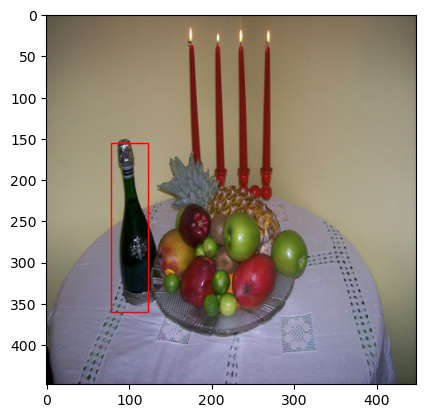

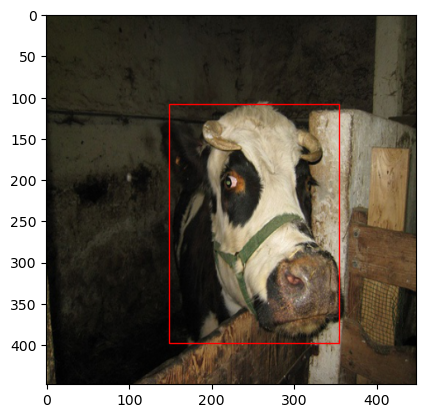

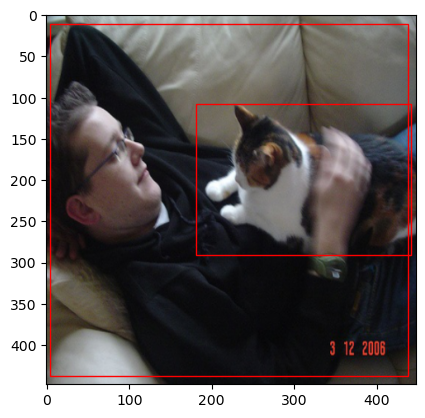

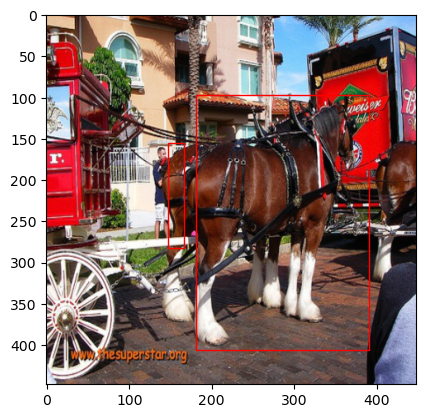

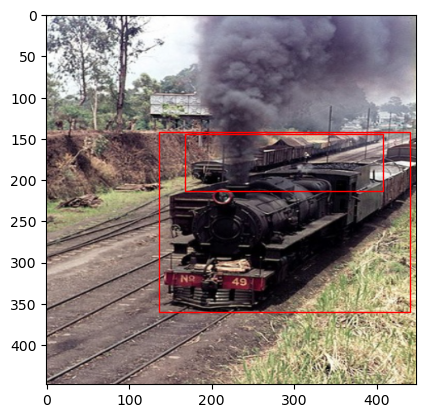

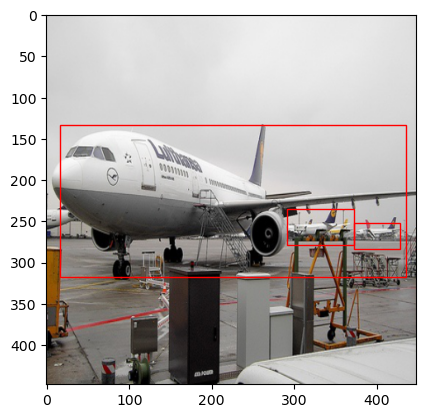

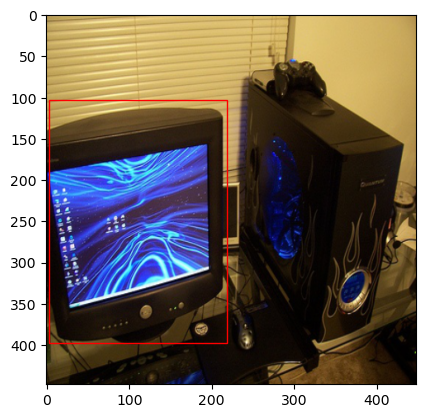

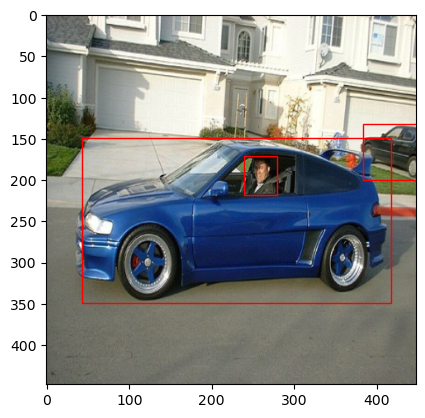

SystemExit: 

C:\Users\moham\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        for x, y in train_loader:
            x = x.to(DEVICE)
            for idx in range(8):
                bboxes = cellboxes_to_boxes(model(x))
                bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
                plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            import sys
            sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

#        if mean_avg_prec > 0.9:
#             checkpoint = {
#                "state_dict": model.state_dict(),
#                "optimizer": optimizer.state_dict(),
#             }
#             save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
#             import time
#             time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()

In [16]:
%tb

SystemExit: 